This notebook is a playspace for practicing and learning Bayesian estimation using MCMC methods. We'll implement everything from scratch and use a simulated univariate bernoulli event as the test case.

Steps:
- Create a data generating mechanism that represents the univariate bernoulli event
- Write processes for running MCMC with Metropolis-Hastings (done) and Gibbs Sampling (not done)
- Estimate the parameters of the LogReg using MCMC
- Validation and further exploration

Some good references:
- [Columbia tutorial](http://www.columbia.edu/~mh2078/MachineLearningORFE/MCMC_Bayes.pdf)
- [Some dude's good Medium post](https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Create a Data Generating Mechanism

In [2]:
def inv_logit(XB):
    return 1 / (1 + np.exp(-1*XB))

def gen_logistic_dataframe(alpha, betas, N):
    '''
    create a dataframe with N examples that represents a bernoulli process 
    '''
    K = len(betas)
    X = np.random.normal(size = [N,K])
    XB = X.dot(betas) + alpha
    Y = 1*(inv_logit(XB) > np.random.uniform(size=N))
    df = pd.DataFrame(X, columns = ['X_{}'.format(i+1) for i in range(K)])
    df['Y'] = Y
    return df

### Build Functions for MCMC Sampling

To do MCMC, we need a few things. 

Metropolis-Hastings
- Log-Likelihood function $p(D|\alpha, \beta) = \Sigma y*log(p)+(1-y)*log(1-p)$ for computing the log-likelihood of the data
- Prior function for $p(\beta)$. For this we may want multiple candidate priors.
- A proposal function $Q(\theta^{t+1}|\theta^t)$ for generating candidates in each MCMC step
- An acceptance probability formula $min\{(p'(y)/p'(x)*(Q(x|y)/Q(y|x), 1\}$, where p'(x)=likelihood*prior
- An overall all wrapper for the MCMC-MH algorithm

#### Generic MCMC Algos

In [3]:
class metropolis_hastings(object):
    '''
    '''
    
    def __init__(self, prior, log_likelihood, proposal, theta_init):
        self.prior = prior
        self.log_likelihood = log_likelihood
        self.proposal = proposal
        self.theta_init = theta_init
        self.accepted = []
        self.rejected = []
    
    def acceptance_rate(self, p_old_log, p_new_log, q_old_log, 
                        q_new_log, prior_old, prior_new):
        if (p_new_log + prior_new + q_old_log) > (p_old_log + prior_old + q_new_log):
            return 1.0
        else:
            log_ratio = (p_new_log + prior_new + q_old_log) - (p_old_log + prior_old + q_new_log) 
            return np.exp(log_ratio)
        
    def gen_n_samples(self, n, evidence):
        
        if len(self.accepted)==0:
            theta = self.theta_init
        else:
            theta = self.accepted[-1]
            
        i = 0
        j=0
        while i<n:
            #Generate a proposal
            theta_new = self.proposal.gen_next(theta)
            p_old_log = self.log_likelihood(evidence, theta)
            p_new_log = self.log_likelihood(evidence, theta_new)
            prior_old = self.prior(theta)
            prior_new = self.prior(theta_new)
            q_old_log = self.proposal.gen_log_p(theta, theta_new)
            q_new_log = self.proposal.gen_log_p(theta_new, theta)
            
            alpha = self.acceptance_rate(p_old_log, p_new_log, q_old_log, 
                                    q_new_log, prior_old, prior_new)
            
            ru = np.random.uniform()
            
            if alpha > ru:
                self.accepted.append(theta_new)
                theta = theta_new
                i+=1
            else:
                self.rejected.append(theta_new)
              
            j+=1
            if j>10*n:
                print('Failed to converge')
                break

In [4]:
#These are all of the ingredients to the algorithm

from scipy.stats import norm

class proposal_norm_ind(object):
    '''
    Can work for any arbitrary length param vector
    ''' 
    
    def __init__(self, sig):
        self.sig = sig
    
    def gen_next(self, theta):
        d = len(theta)
        return np.random.normal(theta, self.sig*np.ones(d))
    
    def gen_log_p(self, point, mu):
        d = len(mu)
        return np.log(norm.pdf(point, mu, self.sig*np.ones(d))).sum()

class log_uniform_ind(object):
    
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def check_uni(self, x):    
        if (self.a <= x <= self.b):
            return (self.b-self.a)**-1
        else:
            return 0
        
    def gen_log_p(self, theta):
        log_prior = 0
        for th in theta:
            log_prior += np.log(self.check_uni(th))
        return log_prior
    
class log_normal_ind(object):
    '''
    mu, sigma and theta must be same dimension or it throws an error
    assumes fully independent samples
    '''
    
    def __init__(self, mu, sig):
        self.mu = mu
        self.sig = sig
        
    def gen_log_p(self, theta):
        log_prior = np.log(norm.pdf(theta, self.mu, self.sig)).sum()
        return log_prior
    
    
def log_likelihood_log_reg(df, theta):
    alpha = theta[0]
    betas = theta[1:]
    ys = df['Y']
    XB = df.drop('Y', axis=1).dot(np.array(betas)) + alpha
    ps = 1 / (1 + np.exp(-1*XB))
    return (ys*np.log(ps) + (1-ys)*np.log((1-ps))).sum()


### Now let's test things

First we'll look at a uniform prior over a reasonable interval. This should match the MLE estimates, which we can verify.

In [5]:
#Metropolis-Hastings

#Generate data
truth = [-1, 1]
df = gen_logistic_dataframe(truth[0], truth[1:], 1000)

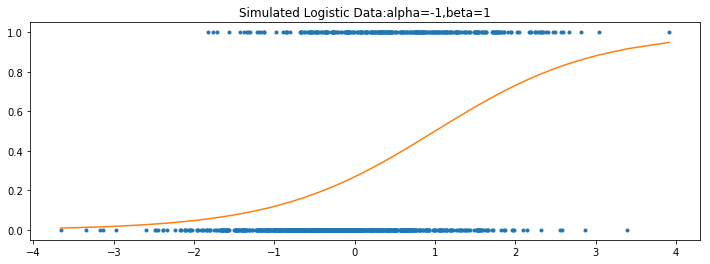

In [63]:
if len(truth)==2:
    df_s = df.sort_values(by='X_1', inplace=False)
    plt.figure(figsize=(12,4))
    plt.plot(df_s.X_1, df_s.Y,'.')
    plt.plot(df_s.X_1, 1/(1+np.exp(-1*(truth[0]+truth[1]*df_s.X_1))))
    plt.title('Simulated Logistic Data:alpha={},beta={}'.format(truth[0], truth[1]))

In [6]:
#Initialize everything
alpha_init = np.log(df.Y.mean() / (1-df.Y.mean()))
theta_init = [alpha_init] + list(np.zeros(df.shape[1]-1))

prior = log_uniform_ind(-5, 5).gen_log_p
log_likelihood = log_likelihood_log_reg
proposal = proposal_norm_ind(0.2)

In [7]:
mh1 = metropolis_hastings(prior, log_likelihood, proposal, theta_init)

In [14]:
#Generate some samples
mh1.gen_n_samples(5000, df)

In [15]:
#Generate the MLE estimate as validation
import statsmodels.api as sm
logit_sm = sm.Logit(df['Y'], sm.add_constant(df.drop('Y', 1)))
lr1 = logit_sm.fit()
lr1.summary()

Optimization terminated successfully.
         Current function value: 0.540698
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Tue, 29 Jan 2019   Pseudo R-squ.:                  0.1244
Time:                        15:06:37   Log-Likelihood:                -540.70
converged:                       True   LL-Null:                       -617.49
                                        LLR p-value:                 2.852e-35
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9752      0.078    -12.467      0.000      -1.129      -0.822
X_1            0.9252      0.084     11.070      0.000       0.761       1.089
==============================================================================
"""

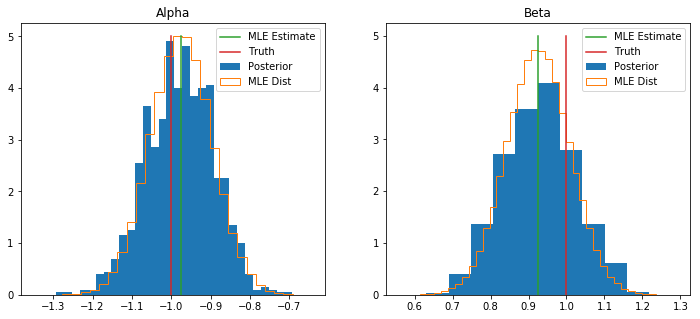

In [66]:
#Plot posteriors for alpha and beta along with MLE estimates
last = 1000
def make_some_plots(mh_i, lr_i):
    last = 1000
    fig = plt.figure(figsize = (12,5))
    fig.add_subplot(121)
    h = plt.hist(np.array(mh_i.accepted)[-last:,0], density=True, bins=30, label='Posterior')
    h = plt.hist(np.random.normal(lr_i.params[0], lr_i.bse[0], 100000), bins = 30, 
             density=True, histtype='step', label='MLE Dist')
    plt.plot(np.ones(2)*lr_i.params[0],[0,5], label='MLE Estimate')
    plt.plot(np.ones(2)*-1,[0,5], label='Truth')
    plt.title('Alpha')
    plt.legend()
    
    
    fig.add_subplot(122)
    h = plt.hist(np.array(mh_i.accepted)[-last:,1], density=True, label='Posterior')
    h = plt.hist(np.random.normal(lr_i.params[1], lr_i.bse[1], 100000), bins = 40, 
             density=True, histtype='step', label='MLE Dist')
    plt.plot(np.ones(2)*lr_i.params[1],[0,5], label='MLE Estimate')
    plt.plot(np.ones(2)*1,[0,5], label='Truth')
    plt.title('Beta')
    plt.legend()
    
make_some_plots(mh1, lr1)

In [29]:
np.median(np.array(mh1.accepted)[-last:,0]), np.median(np.array(mh1.accepted)[-last:,1])

(-0.977806067140979, 0.9305330614110232)

Now let's look at a Gaussian prior. We'll center the intercept around the log of the base rate odds ratio.

In [67]:
#Initialize everything
prior_norm = log_normal_ind([alpha_init, 0], [2,2]).gen_log_p
mh_norm2 = metropolis_hastings(prior_norm, log_likelihood, proposal, [alpha_init, 0])
mh_norm2.gen_n_samples(4000, df)

In [69]:
mh_norm2.gen_n_samples(3000, df)

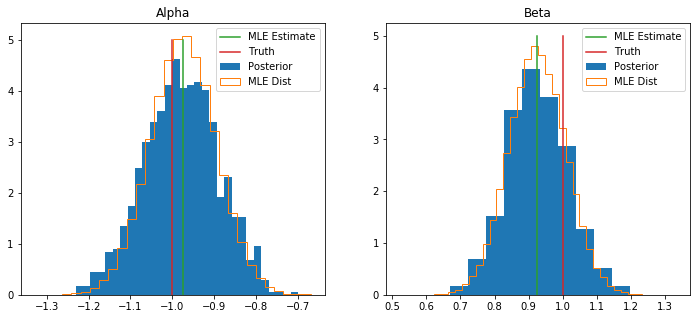

In [68]:
#Plot posteriors for alpha and beta along with MLE estimates
make_some_plots(mh_norm2, lr1)

Let's get some MC distributions for predictions

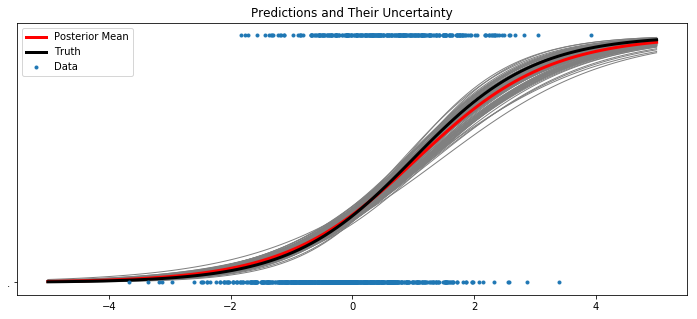

In [140]:
def prediction_posterior(post_a, post_b, xs):
    alpha = np.random.choice(post_a, size=1)[0]
    beta = np.random.choice(post_b, size=1)[0]
    return 1 / (1+np.exp(-1*(alpha + xs*beta)))


xs = np.linspace(-5,5,100)

n=100
ps = []
for i in range(n):
    ps.append(prediction_posterior(np.array(mh_norm2.accepted)[-3000:,0],
                             np.array(mh_norm2.accepted)[-3000:,1],
                             xs))


ps = np.array(ps)
    
fig = plt.figure(figsize=(12,5))
for i in range(n):
    plt.plot(xs, ps[i,:], 'gray', '.',linewidth=1,markersize=1)
    
plt.plot(xs,ps.mean(axis=0), 'r', label='Posterior Mean', linewidth=3)
plt.plot(xs, 1/(1+np.exp(-1*(truth[0]+truth[1]*xs))), 'black', linewidth=3,
         label='Truth')

plt.plot(df_s.X_1, df_s.Y,'.', label='Data')

plt.title('Predictions and Their Uncertainty')
plt.legend()

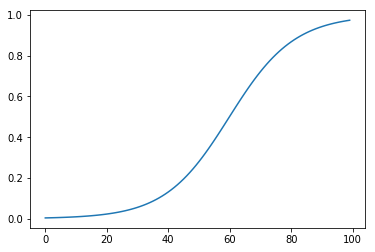

In [567]:
np.median(np.array(mh_norm2.accepted)[-last:,0]), np.median(np.array(mh_norm2.accepted)[-last:,1])

(-0.8285112107835384, 0.7978717734941596)

Lets see what happens when we use different starting values

In [53]:
prior_norm = log_normal_ind([alpha_init, 0], [2,2]).gen_log_p
mh_mle = metropolis_hastings(prior_norm, log_likelihood, proposal, [lr1.params[0],lr1.params[1]])
mh_mle.gen_n_samples(500, df)

mh_prior = metropolis_hastings(prior_norm, log_likelihood, proposal, [alpha_init,0])
mh_prior.gen_n_samples(500, df)

mh_bad = metropolis_hastings(prior_norm, log_likelihood, proposal, [2,2])
mh_bad.gen_n_samples(500, df)


Look at trace plots of a good distributions

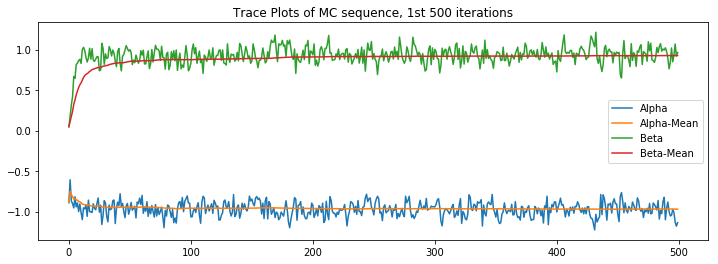

In [49]:
def cum_average(a) :
    os = np.cumsum(np.ones(len(a)))
    ret = np.cumsum(a, dtype=float) 
    return ret / os

fig = plt.figure(figsize=(12,4))
plt.plot(np.array(mh1.accepted)[:500,0], label='Alpha')
plt.plot(cum_average(np.array(mh1.accepted)[:500,0]), label='Alpha-Mean')
plt.plot(np.array(mh1.accepted)[:500,1], label='Beta')
plt.plot(cum_average(np.array(mh1.accepted)[:500,1]), label='Beta-Mean')
plt.title('Trace Plots of MC sequence, 1st 500 iterations')
plt.legend()



Trace plots based on different starting points

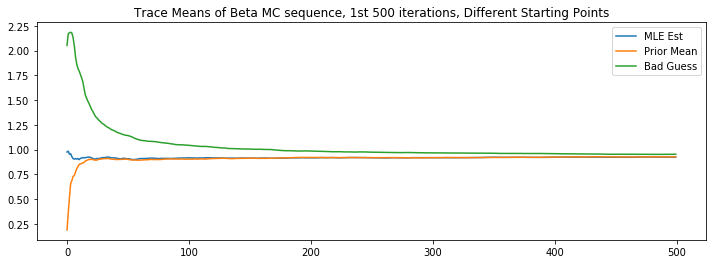

In [55]:
fig = plt.figure(figsize=(12,4))
plt.plot(cum_average(np.array(mh_mle.accepted)[:500,1]), label='MLE Est')
plt.plot(cum_average(np.array(mh_prior.accepted)[:500,1]), label='Prior Mean')
plt.plot(cum_average(np.array(mh_bad.accepted)[:500,1]), label='Bad Guess')
plt.title('Trace Means of Beta MC sequence, 1st 500 iterations, Different Starting Points')
plt.legend()

It looks like MLE and MCMC are giving close to the same results. This is likely because our sample sizes are sufficient for good learning. Let's see how much the prior variance impacts the difference between MCMC and MLE.

In [141]:
alpha_init = np.log(df.Y.mean() / (1-df.Y.mean()))
theta_init = [alpha_init] + list(np.zeros(df.shape[1]-1))
logit_sm = sm.Logit(df['Y'], sm.add_constant(df.drop('Y', 1)))
lr_i = logit_sm.fit()

stds = [0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 4, 10]

mh = []
for s in stds:
    print('starting {}'.format(s))
    prior_norm = log_normal_ind([0, 0], [s,s]).gen_log_p
    mh_sm = metropolis_hastings(prior_norm, log_likelihood, proposal, theta_init)
    mh_sm.gen_n_samples(5000, df)
    mh.append(mh_sm)

Optimization terminated successfully.
         Current function value: 0.540698
         Iterations 6
starting 0.005


/Users/briandalessandro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/briandalessandro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Failed to converge
starting 0.01
Failed to converge
starting 0.05
Failed to converge
starting 0.1
starting 0.5
starting 1
starting 2
starting 4
starting 10


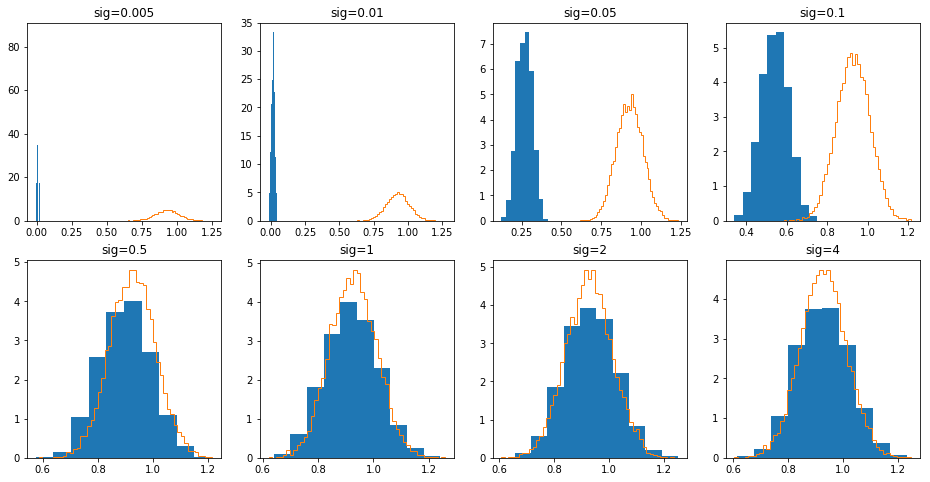

In [148]:
plt.figure(figsize=(16,8))
for j, s in enumerate(stds[:-1]):
    mh_sm = mh[j]
    ax=plt.subplot(2,4,j+1)
    last=1000
    plt.title('sig={}'.format(s))
    
    h = plt.hist(np.array(mh_sm.accepted)[50:,1], density=True)
    h = plt.hist(np.random.normal(lr_i.params[1], lr_i.bse[1], 10000), bins = 50, 
             density=True, histtype='step')

Let's try everything on the beta-binomial distribution to do one more test.

In [149]:
from scipy.stats import beta
from scipy.special import binom

class log_beta(object):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    def gen_log_p(self, theta):
        log_prior = np.log(beta.pdf(theta, self.alpha, self.beta)).sum()
        return log_prior
    
def log_likelihood_beta(df, theta):
    p = theta[0]
    n = df.shape[0]
    x = df['Y'].sum()
    return x*np.log(p)+(n-x)*np.log(1-p)+np.log(binom(n,x))

#Gen data
def gen_binom_df(n, p):
    return pd.DataFrame({'Y':1*(np.random.uniform(size=n)<p)})


In [150]:
d1 = gen_binom_df(100,0.25)
prior_beta = log_beta(1,1).gen_log_p
mh_b = metropolis_hastings(prior_beta, log_likelihood_beta, proposal, [d1['Y'].mean()])
mh_b.gen_n_samples(10000, d1)


/Users/briandalessandro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
/Users/briandalessandro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


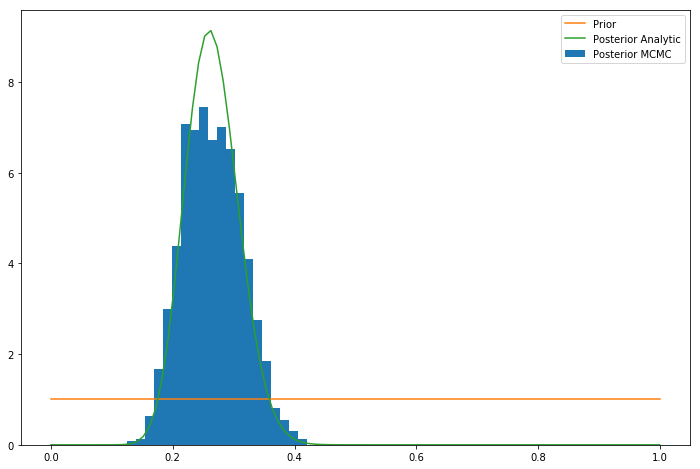

In [154]:
lin = np.linspace(0,1,100)

plt.figure(figsize=(12,8))
n = d1.shape[0]
x = d1['Y'].sum()
last = 5000
h = plt.hist(np.array(mh_b.accepted)[-last:], density=True, label='Posterior MCMC', bins=20)
plt.plot(lin, beta.pdf(lin,1,1), label='Prior')
plt.plot(lin, beta.pdf(lin,1+x,1+n-x), label='Posterior Analytic')
plt.legend()

Ok. So it seems to be working.